## Fraud Prediction

### Load Libraries
    * Libraries for data preparation
    * Fast ML Libraries for data imputation and encoding
        - for installing fast-ml use command "pip install fast-ml" in command prompt
    * sklearn libraries for modelling, confusion matrix and prediction
    

In [1]:
!pip install fast_ml --upgrade

In [2]:
#Import os, pandas and numpy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from lightgbm import LGBMClassifier
import datetime

In [3]:
from fast_ml.eda import categorical_plots,numerical_plots
from fast_ml.missing_data_analysis import MissingDataAnalysis
from fast_ml.missing_data_imputation import MissingDataImputer_Categorical, MissingDataImputer_Numerical
from fast_ml.utilities import rare_encoding
from fast_ml.feature_engineering import FeatureEngineering_Categorical,FeatureEngineering_Numerical
from fast_ml.utilities import reduce_memory_usage
from fast_ml.eda import categorical_plots,numerical_plots,categorical_plots_with_target,numerical_plots_with_target,numerical_bins_with_target


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

#### Functions

* "compare_Numerical_distribution" function to compare distribution of numerical data before and after imputation
* "clustercheck" to check if the set of variables belong to the same cluster.
* "Browser_transform","OS_transform" and "Mail_transform" to normalize the observation in variables,

In [5]:

def compare_Numerical_distribution(df1,df2,variables):
    df = pd.DataFrame()
    msg_value = []
    data = []
    for a in variables:
        df_mean = df1[a].mean() - df2[a].mean()
        df_std = df1[a].std() - df2[a].std()
        if int(df_mean) == 0:
            msg_mean = "Mean of both the dataset is same" #+ str(df1[a].mean()) + str(df2[a].mean()) 
        else:
            msg_mean = "Mean of both the dataset differ by " + str(df_mean)
        if int(df_std) == 0:
            msg_std = "Standard Dev. of both the dataset is same"
        else:
            msg_std = "Standard Dev the dataset differ by " + str(df_std) 
            
        if int(df_mean) == 0 and int(df_std) ==0:
            msg_Remark = "Distribution for dataset is same"
            
        else:
            msg_Remark = "Distribution for dataset is different"
            
        msg_value = [a,msg_mean,msg_std,msg_Remark] 
        zipped  = zip(["Variable","Mean","Stdev","Remark"],msg_value)
        a_dict = dict(zipped)
        data.append(a_dict)
    df= df.append(data,True)
    return(df)


def clustercheck(df,base,cluster):
    nullcount = df[base].isnull().sum()
    LiTrue = []
    LiFalse = []
    for a in cluster:
        if df[a].isnull().sum() == nullcount:
            LiTrue.append(a)
        else:
            LiFalse.append(a)

    print("List of elements having same missing value is", LiTrue)
    print("List of elements having different missing value is", LiFalse)
    
def Browser_transform(df,col):
    df.loc[df[col].str.contains('chrome', na=False), col] = 'Chrome'
    df.loc[df[col].str.contains('firefox', na=False), col] = 'Firefox'
    df.loc[df[col].str.contains('safari', na=False), col] = 'Safari'
    df.loc[df[col].str.contains('edge', na=False), col] = 'Edge'
    df.loc[df[col].str.contains('ie', na=False), col] = 'IE'
    df.loc[df[col].str.contains('samsung', na=False), col] = 'Samsung'
    df.loc[df[col].str.contains('opera', na=False), col] = 'Opera'
    #df.loc[df[col].str.contains('Others', na=False), col] = 'other'
    df[col].fillna("Missing", inplace=True)
    df.loc[df.id_31.isin(df.id_31.value_counts()[df.id_31.value_counts() < 200].index), col] = "other"
    
def OS_transform(df,col):
    df.loc[df[col].str.contains('Windows', na=False), col] = 'Windows'
    df.loc[df[col].str.contains('iOS', na=False), col] = 'iOS'
    df.loc[df[col].str.contains('Mac OS', na=False), col] = 'Mac'
    df.loc[df[col].str.contains('Android', na=False), col] = 'Android'
    df[col].fillna("Missing", inplace=True)
    
def Mail_transform(df,col):
    df.loc[df[col].str.contains('gmail', na=False), col] = 'gmail.com'
    df.loc[df[col].str.contains('yahoo', na=False), col] = 'yahoo.com'
    df.loc[df[col].str.contains('outlook', na=False), col] = 'outlook.com'
    df.loc[df[col].str.contains('hotmail', na=False), col] = 'hotmail.com'
    df[col].fillna("Missing", inplace=True)
    
def Remove_dup(x):
    return list(dict.fromkeys(x))

    #return df   


### Import Data

In [6]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
n = 590540 #number of records in file
s = 50000 #desired sample size
filename = "/content/gdrive/My Drive/Colab Notebooks/fraud/train_transaction.csv"
skip = sorted(random.sample(range(n),n-s))
train = pd.read_csv(filename, skiprows=skip[1:])
#train_transaction =  pd.read_csv("")
#train_identity = pd.read_csv("D:\\Kaggle\\Fraud_Detection\\train_identity.csv")
#train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [8]:
train = reduce_memory_usage(train, convert_to_category=False)

Memory usage of dataframe is 150.30 MB
Memory usage after optimization is: 44.11 MB
Decreased by 70.7%


## Test Train Split

* Create Test, Train and Validate DataSet

In [9]:
y = train['isFraud']
x_train = train.drop('isFraud', axis =1)
from sklearn.model_selection import train_test_split
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y, test_size=0.2, random_state=0)
#from sklearn.model_selection import train_test_split
x_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [10]:
#from sklearn.model_selection import train_test_split
x_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [11]:
x_train.shape,y_train.shape

((32000, 393), (32000,))

In [12]:
X_test.shape,y_test.shape

((8000, 393), (8000,))

In [13]:
x_valid.shape,y_valid.shape

((10001, 393), (10001,))

#####  Identify variables Based on EDA performed

In [14]:
Rare_2 =['P_emaildomain']
Rare_4 =['R_emaildomain']
#'D5' : [0,30,40,50,60,70,80,90,100],
Custom_Bin ={
'TransactionAmt' : [0,10,20,40,50,60,70,90,100],
'C1' : [0,50,70,80,90,100],
'C2' : [0,50,70,80,90,100],
'C4' : [0,70,90,100],
'C5' : [0,60,80,90,100],
'C6' : [0,60,80,90,100],
'C7' : [0,80,90,100],
'C8' : [0,70,90,100],
'C9' : [0,60,80,90,100],
'C10' : [0,70,90,100],
'C11' : [0,60,80,90,100],
'C12' : [0,80,90,100],
'C13' : [0,10,50,60,70,80,90,100],
'C14' : [0,80,90,100],
'D1' : [0,50,60,70,80,90,100],
'addr1' : [0,90,100],
'D10' : [0,50,60,70,80,90,100],
'D15' : [0,30,40,50,60,70,80,90,100],
'D4' : [0,10,50,60,70,80,90,100],
'D3' : [0,30,40,50,60,100],
'D2' : [0,10,20,30,40,50,60,70,100],
'D11' : [0,40,50,60,70,80,90,100],
'D6' : [0,70,80,90,100],
'D12' : [0,70,80,90,100],
'D14' : [0,70,80,90,100],
'D13' : [0,90,100],
'D7' : [0,60,90,100],'V330': [0, 90, 100],'V329': [0, 90, 100],'V326': [0, 90, 100],'V334': [0, 98, 100],
'V337': [0, 95, 100],'V339': [0, 90, 100],	'V336': [0, 95, 100],	'V338': [0, 90, 100],	'V322': [0, 95, 100],
             'V324': [0, 80, 100],	'V323': [0, 90, 100],	'V335': [0, 90, 100],	'V331': [0, 90, 100],
             'V333': [0, 80, 100],	'V332': [0, 80, 100],	'V311': [0, 98, 100],	'V319': [0, 98, 100],
             'V321': [0, 95, 100],	'V309': [0, 95, 100],	'V320': [0, 95, 100],	'V316': [0, 95, 100],
             'V313': [0, 90, 100],	'V318': [0, 95, 100],	'V315': [0, 90, 100],	'V312': [0, 80, 90, 100],
             'V317': [0, 90, 100],	'V306': [0, 90, 100],	'V314': [0, 90, 100],	'V308': [0, 80, 100],
             'V310': [0, 70, 80, 90, 100],'V307': [0, 60, 80, 100]}



In [15]:
Adaptive_10p = ['card1' ,'card3','card5' ,'card2' ,'dist1' ,'D8','dist2','V225',	'V193',	'V190',	'V170',	'V237',
                'V176',	'V192',	'V199',	'V261',	'V171',	'V243',	'V254',	'V236',	'V246',	'V255',	'V256',	'V257',	'V227',
                'V299',	'V151',	'V182',	'V228',	'V201',	'V245',	'V290',	'V283',	'V144',	'V180',	'V230',	'V253',	'V258',
                'V259',	'V222',	'V221',	'V224',	'V226',	'V229',	'V296',	'V298',	'V285',	'V187',	'V234',	'V269',	'V292',	
                'V291',	'V145',	'V177',	'V167',	'V143',	'V179',	'V168',	'V178',	'V231',	'V217',	'V233',	'V232',	'V219',
                'V218',	'V166',	'V164',	'V129',	'V293',	'V279',	'V295',	'V165',	'V280',	'V150',	'V135',	'V294',	'V137',
                'V206',	'V159',	'V136',	'V266',	'V131',	'V205',	'V132',	'V270',	'V160',	'V272',	'V208',	'V210',	'V276',
                'V214',	'V268',	'V271',	'V278',	'V134',	'V216',	'V277',	'V209',	'V207',	'V215',	'V267',	'V126',	'V133',
                'V128',	'V273',	'V275',	'V130',	'V211',	'V127',	'V274',	'V213',	'V212',	'V263',	'V202',	'V265',	'V204',
                'V264',	'V203']
Adaptive_5p = ['V200',	'V106',	'V105',	'V161',	'V163',	'V162',	'V101',	'V103',	'V102']


In [16]:
Rare_5 = ['ProductCD',	'card4',	'card6',	'addr2',	'M6',	'M1',	'M2',	'M3',	'M4',	'M7',	'M8',	'M9',	'M5',	'D9',
'V9',	'V8',	'V5',	'V4',	'V3',	'V2',	'V11',	'V10',	'V50',	'V49',	'V48',	'V42',	'V41',	'V40',	'V36',	'V35',	'V94',	'V93',
          'V92',	'V91',	'V90',	'V89',	'V88',	'V87',	'V86',	'V85',	'V84',	'V83',	'V82',	'V81',	'V80',	'V79',	'V77',	'V74',	'V73',
          'V72',	'V71',	'V70',	'V69',	'V68',	'V67',	'V65',	'V64',	'V63',	'V62',	'V60',	'V59',	'V58',	'V57',	'V55',	'V53',	'V34',
          'V33',	'V32',	'V31',	'V30',	'V29',	'V28',	'V27',	'V26',	'V25',	'V24',	'V22',	'V21',	'V19',	'V18',	'V17',	'V16',	'V15',
          'V14',	'V13',	'V12',	'V98','V141',	'V173',	'V325',	'V142',	'V174',	'V194',	'V197',	'V301',	'V153',	'V302',	'V304',	'V148',	'V154',
          'V155',	'V157',	'V175',	'V184',	'V123',	'V195',	'V303',	'V138',	'V328',	'V146',	'V156',	'V327',	'V158',	'V198',	'V147',	'V185',	'V181',
          'V169',	'V188']
Rare_10 = ['V107',	'V117',	'V118',	'V119',	'V120',	'V121',	'V122',	'V108',	'V109',	'V110',	'V111',	'V112',	'V113',	'V114',	'V115',	'V116',	'V124',
           'V125',	'V104']


In [17]:
# Variable to drop
Var_to_Drop = ['C3','TransactionID','TransactionDT']

##### Drop unwanted Variables

In [18]:
x_train = x_train.drop(Var_to_Drop,axis=1)
x_valid = x_valid.drop(Var_to_Drop,axis=1)

##### Feature engineering to string variables

In [19]:
#Browser_transform(x_train,'id_31')
#OS_transform(x_train,'id_30')
Mail_transform(x_train,'P_emaildomain')
Mail_transform(x_train,'R_emaildomain')

#Browser_transform(x_valid,'id_31')
#OS_transform(x_valid,'id_30')
Mail_transform(x_valid,'P_emaildomain')
Mail_transform(x_valid,'R_emaildomain')

### Rare Encoding

In [20]:
rare_encoder2 = FeatureEngineering_Categorical( method='rare')
rare_encoder2.fit(x_train, Rare_2, target=None, rare_tol=2)
x_train = rare_encoder2.transform(x_train)
x_valid = rare_encoder2.transform(x_valid)

In [21]:
rare_encoder3 = FeatureEngineering_Categorical( method='rare')
rare_encoder3.fit(x_train, Rare_4, target=None, rare_tol=4)
x_train = rare_encoder3.transform(x_train)
x_valid = rare_encoder3.transform(x_valid)

In [22]:
rare_encoder4 = FeatureEngineering_Categorical( method='rare')
rare_encoder4.fit(x_train, Rare_5, target=None, rare_tol=5)
x_train = rare_encoder4.transform(x_train)
x_valid = rare_encoder4.transform(x_valid)

In [23]:
rare_encoder5 = FeatureEngineering_Categorical( method='rare')
rare_encoder5.fit(x_train, Rare_10, target=None, rare_tol=10)
x_train = rare_encoder5.transform(x_train)
x_valid = rare_encoder5.transform(x_valid)

### Binning

In [24]:
### ADAPTIVE 10 PERCENTILE BINNING 

from fast_ml.feature_engineering import FeatureEngineering_Numerical
num_binner = FeatureEngineering_Numerical(method = '10p', adaptive = True)
num_binner.fit(x_train, Adaptive_10p)
x_train = num_binner.transform(x_train)
x_valid = num_binner.transform(x_valid)

In [25]:
### ADAPTIVE 5 PERCENTILE BINNING 
num_binner2 = FeatureEngineering_Numerical(method = '5p', adaptive = True)
num_binner2.fit(x_train, Adaptive_5p)
x_train = num_binner2.transform(x_train)
x_valid = num_binner2.transform(x_valid)

In [26]:
for key, value in Custom_Bin.items():
    num_bin_custom = FeatureEngineering_Numerical(method = 'custom', adaptive = False, custom_buckets= value)
    num_bin_custom.fit(x_train,[key])
    print(key,value)
    x_train = num_bin_custom.transform(x_train)
    x_valid = num_bin_custom.transform(x_valid)

TransactionAmt [0, 10, 20, 40, 50, 60, 70, 90, 100]
C1 [0, 50, 70, 80, 90, 100]
C2 [0, 50, 70, 80, 90, 100]
C4 [0, 70, 90, 100]
C5 [0, 60, 80, 90, 100]
C6 [0, 60, 80, 90, 100]
C7 [0, 80, 90, 100]
C8 [0, 70, 90, 100]
C9 [0, 60, 80, 90, 100]
C10 [0, 70, 90, 100]
C11 [0, 60, 80, 90, 100]
C12 [0, 80, 90, 100]
C13 [0, 10, 50, 60, 70, 80, 90, 100]
C14 [0, 80, 90, 100]
D1 [0, 50, 60, 70, 80, 90, 100]
addr1 [0, 90, 100]
D10 [0, 50, 60, 70, 80, 90, 100]
D15 [0, 30, 40, 50, 60, 70, 80, 90, 100]
D4 [0, 10, 50, 60, 70, 80, 90, 100]
D3 [0, 30, 40, 50, 60, 100]
D2 [0, 10, 20, 30, 40, 50, 60, 70, 100]
D11 [0, 40, 50, 60, 70, 80, 90, 100]
D6 [0, 70, 80, 90, 100]
D12 [0, 70, 80, 90, 100]
D14 [0, 70, 80, 90, 100]
D13 [0, 90, 100]
D7 [0, 60, 90, 100]
V330 [0, 90, 100]
V329 [0, 90, 100]
V326 [0, 90, 100]
V334 [0, 98, 100]
V337 [0, 95, 100]
V339 [0, 90, 100]
V336 [0, 95, 100]
V338 [0, 90, 100]
V322 [0, 95, 100]
V324 [0, 80, 100]
V323 [0, 90, 100]
V335 [0, 90, 100]
V331 [0, 90, 100]
V333 [0, 80, 100]
V332 [

In [27]:
cat_imputer = MissingDataImputer_Categorical(method = 'custom_value',add_indicator=False,value = 'Missing')
cat_imputer.fit(x_train, variables = Rare_5)
x_train = cat_imputer.transform(x_train)
x_valid = cat_imputer.transform(x_valid)

cat_imputer2 = MissingDataImputer_Categorical(method = 'custom_value',add_indicator=False,value = 'Missing')
cat_imputer2.fit(x_train, variables = Rare_10)
x_train = cat_imputer2.transform(x_train)
x_valid = cat_imputer2.transform(x_valid)

In [28]:
licol = x_train.columns
mda_obj = MissingDataAnalysis(x_train[licol], target='isfraud', model = 'Classification' )
X_miss = mda_obj.calculate_missing_values()
x_missvar = X_miss.variables
catcol =[]
numcol = []
for col in x_missvar:
    if len(x_train[col].unique()) <=20 :
        catcol.append(col)
    else:
        numcol.append(col)
#catcol.extend(["id_31","id_33","DeviceInfo"])
#numcol.remove("id_33")
#numcol.remove("DeviceInfo")
rare_encoder1 = FeatureEngineering_Categorical( method='rare')
rare_encoder1.fit(x_train, catcol, target=None, rare_tol=5)
x_train = rare_encoder1.transform(x_train)
x_valid = rare_encoder1.transform(x_valid)

num_binner3 = FeatureEngineering_Numerical(method = '5p', adaptive = True)
num_binner3.fit(x_train, numcol)
x_train = num_binner3.transform(x_train)
x_valid = num_binner3.transform(x_valid)


In [29]:
#x_train['variable'].head()

### Label Encoding -  Avoid Label Encoding Just RUN One Hot

In [30]:
label_encoder = FeatureEngineering_Categorical( method='label')
label_encoder.fit(x_train,variables= Rare_5)
x_train= label_encoder.transform(x_train)
x_valid = label_encoder.transform(x_valid)

In [31]:
label_encoder2 = FeatureEngineering_Categorical( method='label')
label_encoder2.fit(x_train,variables= Rare_10)
x_train= label_encoder2.transform(x_train)
x_valid = label_encoder2.transform(x_valid)

In [32]:
label_encoder3 = FeatureEngineering_Categorical( method='label')
label_encoder3.fit(x_train,variables= Rare_10)
x_train= label_encoder3.transform(x_train)
x_valid = label_encoder3.transform(x_valid)

In [33]:
label_encoder4 = FeatureEngineering_Categorical( method='label')
label_encoder4.fit(x_train,variables= catcol)
x_train= label_encoder4.transform(x_train)
x_valid = label_encoder4.transform(x_valid)

In [34]:
#label_encoder4 = FeatureEngineering_Categorical( method='label')
label_encoder4.fit(x_train,variables= Adaptive_10p)
x_train= label_encoder4.transform(x_train)
x_valid = label_encoder4.transform(x_valid)

In [35]:
label_encoder5 = FeatureEngineering_Categorical( method='label')
label_encoder5.fit(x_train,variables= Adaptive_5p)
x_train= label_encoder5.transform(x_train)
x_valid = label_encoder5.transform(x_valid)

In [36]:
label_encoder6 = FeatureEngineering_Categorical( method='label')
label_encoder6.fit(x_train,variables= numcol)
x_train= label_encoder6.transform(x_train)
x_valid = label_encoder6.transform(x_valid)

In [37]:
listcolumn= ['TransactionAmt','addr1','P_emaildomain','R_emaildomain','C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','D2','D3','D4','D6','D7','D10','D11','D12','D13','D14','D15','V306','V307','V308','V309','V310','V311','V312','V313','V314','V315','V316','V317','V318','V319','V320','V321','V322','V323','V324','V326','V329','V330','V331','V332','V333','V334','V335','V336','V337','V338','V339']

In [38]:
label_encoder7 = FeatureEngineering_Categorical( method='label')
label_encoder7.fit(x_train,variables= listcolumn)
x_train= label_encoder7.transform(x_train)
x_valid = label_encoder7.transform(x_valid)

### One Hot

In [ ]:
Onehot_Encode = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode.fit(x_train,variables= Rare_5)
x_train= Onehot_Encode.transform(x_train)
x_valid = Onehot_Encode.transform(x_valid)

In [ ]:
Onehot_Encode2 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode2.fit(x_train,variables= Rare_10)
x_train= Onehot_Encode2.transform(x_train)
x_valid = Onehot_Encode2.transform(x_valid)

In [ ]:
Onehot_Encode4 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode4.fit(x_train,variables= catcol)
x_train= Onehot_Encode4.transform(x_train)
x_valid = Onehot_Encode4.transform(x_valid)

In [ ]:
#Onehot_Encode4 = FeatureEngineering_Categorical( method='Onehot')
Onehot_Encode4.fit(x_train,variables= Adaptive_10p)
x_train= Onehot_Encode4.transform(x_train)
x_valid = Onehot_Encode4.transform(x_valid)

In [ ]:
Onehot_Encode5 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode5.fit(x_train,variables= Adaptive_5p)
x_train= Onehot_Encode5.transform(x_train)
x_valid = Onehot_Encode5.transform(x_valid)

In [ ]:
Onehot_Encode6 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode6.fit(x_train,variables= numcol)
x_train= Onehot_Encode6.transform(x_train)
x_valid = Onehot_Encode6.transform(x_valid)

In [ ]:
listcolumn= ['TransactionAmt','addr1','P_emaildomain','R_emaildomain','C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','D2','D3','D4','D6','D7','D10','D11','D12','D13','D14','D15','V306','V307','V308','V309','V310','V311','V312','V313','V314','V315','V316','V317','V318','V319','V320','V321','V322','V323','V324','V326','V329','V330','V331','V332','V333','V334','V335','V336','V337','V338','V339']

In [ ]:
Onehot_Encode7 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode7.fit(x_train,variables= listcolumn)
x_train= Onehot_Encode7.transform(x_train)
x_valid = Onehot_Encode7.transform(x_valid)

In [ ]:
DF_Analysis= pd.DataFrame(x_train.dtypes)
DF_Analysis.index.name = "Variable"
DF_Analysis.columns = ["DType"]
DF_Analysis["Unique"] = x_train.nunique()
DF_Analysis["Missing_Count"]=pd.DataFrame(x_train.isnull().sum())
DF_Analysis["Missing_Rate"] = round((x_train.isnull().sum()/x_train.shape[0])*100,2)

DF_Analysis["Cat_Num"] = np.where(DF_Analysis.Unique >=60,"Numerical",(np.where(DF_Analysis.DType == "object",
                                                                     "Categorical","Num_Cat")))
DF_Analysis.sort_values(by = ["Missing_Count"], ascending= False)
DF_Analysis["Imputation_Method"] = np.where(DF_Analysis.Missing_Rate >0,
                                            np.where(DF_Analysis.Cat_Num == "Categorical","Missing",
                                            np.where(DF_Analysis.Cat_Num == "Num_Cat","Missing","Binning")),"Not Applicable")
    #np.where(DF_Analysis.Missing_Rate ==0,"Not Applicable",np.where(DF_Analysis.Cat_Num == "Categorical","Mode",
   # np.where(DF_Analysis.Cat_Num == "Num_Cat","Mode","Mean_Median"))))
DF_Analysis["Drop_Variable"] =  np.where(DF_Analysis.Missing_Rate >=90, "Yes","No")

In [ ]:
DF_Analysis.sort_values(by = 'Unique',ascending=False).head(100)

In [ ]:
#DF_Analysis[DF_Analysis["Cat_Num"] == 'Numerical']

### Normalizing Column names

In [ ]:
litraincolOrg = x_train.columns
litraincol  =  litraincolOrg
livalidcolOrg = x_valid.columns
livalidcol  =  livalidcolOrg

In [ ]:
import re
[str(sentence).replace("' "," ") for sentence in litraincol]
[str(sentence).replace("' "," ") for sentence in livalidcol]

In [ ]:
for a in ["-","."," ","(","]"]:
    litraincol = [str(x).replace(a,"_") for x in litraincol]
    livalidcol = [str(x).replace(a,"_") for x in livalidcol]

In [ ]:
for a in ["_0_","__","_0,"]:
    litraincol = [str(x).replace(a,"_") for x in litraincol]
    livalidcol = [str(x).replace(a,"_") for x in livalidcol]

In [ ]:
for a in [","]:
    litraincol = [str(x).replace(a,"_") for x in litraincol]
    livalidcol = [str(x).replace(a,"_") for x in livalidcol]

In [ ]:
x_train.columns = litraincol
x_valid.columns = livalidcol
    

#### Modelling

In [ ]:
model5 = LGBMClassifier()
model5.fit(x_train, y_train)


In [ ]:
x_train.columns

In [ ]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : model5.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

In [ ]:
predicted = model5.predict(x_valid) 
results = confusion_matrix(y_valid, predicted) 

print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_valid, predicted)) 
print('Report : ')
print(classification_report(y_valid, predicted)) 

### Using Optuna

In [ ]:
import optuna.integration.lightgbm as lgb

In [ ]:
dtrain = lgb.Dataset(x_train, label=y_train)
dval = lgb.Dataset(x_valid, label=y_valid)

In [ ]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

model = lgb.train(
        params, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds=100)

In [ ]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "goss",
    }

model = lgb.train(
        params, dtrain, valid_sets=[dtrain, dval], verbose_eval=2, early_stopping_rounds=2)

In [ ]:
prediction = np.rint(model.predict(x_valid, num_iteration=model.best_iteration))
accuracy = accuracy_score(y_valid, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")

In [ ]:
results = confusion_matrix(y_valid, prediction) 

print('Confusion Matrix :')
print(results) 

In [ ]:
model_n = LGBMClassifier(objective= 'binary', metric= 'binary_logloss', verbosity= -1, boosting_type= 'gbdt',
                       feature_pre_filter= False, lambda_l1= 1.1223456089014623e-08, 
                       lambda_l2= 1.447432290967618e-08, num_leaves= 31, feature_fraction= 0.8999999999999999,
                       bagging_fraction= 1.0, bagging_freq = 0,min_child_samples= 20)
model_n.fit(x_train, y_train)

In [ ]:
litraincolOrg[model_n.feature_importances_]

In [ ]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : model_n.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

##### Reducing stopping rounds

In [ ]:

model2 = lgb.train(
        params, dtrain, valid_sets=[dtrain, dval], verbose_eval=50, early_stopping_rounds=50)

In [ ]:
prediction = np.rint(model2.predict(x_valid, num_iteration=model2.best_iteration))
accuracy = accuracy_score(y_valid, prediction)

best_params = model2.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")

In [ ]:
model_n2 = LGBMClassifier(objective= 'binary', metric= 'binary_logloss', verbosity= -1, boosting_type= 'gbdt',
                         feature_pre_filter= False, lambda_l1= 2.7445577876565753e-06, lambda_l2= 1.0515291002147425e-06, num_leaves= 31, feature_fraction= 0.8999999999999999, bagging_fraction= 0.9880932286085656, bagging_freq= 7, min_child_samples= 20)
model_n2.fit(x_train, y_train)

In [ ]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : model_n2.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

#### Using Hyperopt

In [ ]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import make_scorer

In [ ]:

def gini_sklearn(truth, predictions):
    return gini(truth, predictions) / gini(truth, truth)

gini_scorer = make_scorer(gini_sklearn, greater_is_better=True, needs_proba=True)

In [ ]:
def gini(truth, predictions):
    g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(truth) + 1) / 2.
    return gs / len(truth)

In [ ]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree'])
        
    }
    
    clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    
    score = cross_val_score(clf, x_train, y_train, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

In [ ]:
print("Hyperopt estimated optimum {}".format(best))

In [ ]:
clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        colsample_bytree=  0.5132404769235878, num_leaves =8)

In [ ]:
clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        colsample_bytree= 0.9677129067732777, num_leaves= 88)

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
predicted = clf.predict(x_valid) 
results = confusion_matrix(y_valid, predicted) 

print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_valid, predicted)) 
print('Report : ')
print(classification_report(y_valid, predicted)) 

In [ ]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

In [ ]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'min_child_samples': int(params['min_child_samples'])
        
    }
    
    clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    
    score = cross_val_score(clf, x_train, y_train, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.3, 1.0),
    'min_child_samples': hp.quniform('min_child_samples', 8, 128, 2)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

In [ ]:
format(best)

In [ ]:
clf2 = LGBMClassifier(
colsample_bytree= 0.8489192082676236, feature_fraction= 0.8284137925636559,
    min_child_samples= 40, num_leaves= 12)
clf2.fit(x_train, y_train)

In [ ]:
predicted = clf2.predict(x_valid) 
results = confusion_matrix(y_valid, predicted) 

print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_valid, predicted)) 
print('Report : ')
print(classification_report(y_valid, predicted)) 

In [ ]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf2.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:10]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(7,4))
plt.show()

In [ ]:
clf3 = LGBMClassifier(learning_rate=0.03,
               n_estimators=500, 
colsample_bytree= 0.8489192082676236, feature_fraction= 0.8284137925636559,
    min_child_samples= 40, num_leaves= 31)
clf3.fit(x_train, y_train)

In [ ]:
predicted = clf3.predict(x_valid) 
results = confusion_matrix(y_valid, predicted) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_valid, predicted)) 
print('Report : ')
print(classification_report(y_valid, predicted)) 

In [ ]:
#### Bayesian HyperOpt

In [ ]:
def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05

space = hp.uniform('x', -5, 6)

In [ ]:
from hyperopt import tpe# Create the algorithm
tpe_algo = tpe.suggest
from hyperopt import Trials# Create a trials object
tpe_trials = Trials()

In [ ]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, 
                algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000)

print(tpe_best)

In [ ]:
# Dataframe of results from optimization
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})
                            
tpe_results.head()

In [ ]:
import datetime
START_DATE = '2019-12-01'
X_train = pd.DataFrame()
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
x_train["Date"] = x_train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
x_valid["Date"] = x_valid['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
from fast_ml.feature_engineering import FeatureEngineering_DateTime
dt_encoder = FeatureEngineering_DateTime()

#Scikit-learn type fit() transform() functionality
# Use fit() only on the train dataset
dt_encoder.fit(x_train, ['Date'], prefix = 'default')

# Use transform() on train/test dataset
x_train = dt_encoder.transform(x_train)
x_valid = dt_encoder.transform(x_valid)

In [ ]:
x_train

In [ ]:
x_valid

# using gridserch cv/randomsearchv


In [39]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgbm
from sklearn import metrics 

In [40]:
dtrain = lgbm.Dataset(x_train, label=y_train)
dval = lgbm.Dataset(x_valid, label=y_valid)

classlightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, silent=True, importance_type='split', **kwargs)[source]

In [41]:
clf_LGBM = lgbm.LGBMClassifier(objective='binary')
clf_LGBM.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [42]:
y_pred_train= clf_LGBM .predict(x_train)
y_pred_valid= clf_LGBM .predict(x_valid)
# Model Accuracy, how often is the classifier correct?

print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train)) 

print("Valid Accuracy:",metrics.accuracy_score(y_valid, y_pred_valid))  
print(classification_report(y_valid, y_pred_valid))

Train Accuracy: 0.98365625
Valid Accuracy: 0.9745025497450255
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9649
           1       0.84      0.34      0.48       352

    accuracy                           0.97     10001
   macro avg       0.91      0.67      0.74     10001
weighted avg       0.97      0.97      0.97     10001



In [43]:
clf_LGBM.best_score_
clf_LGBM.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>

In [44]:
litraincolOrg = x_train.columns
livalidcolOrg = x_valid.columns

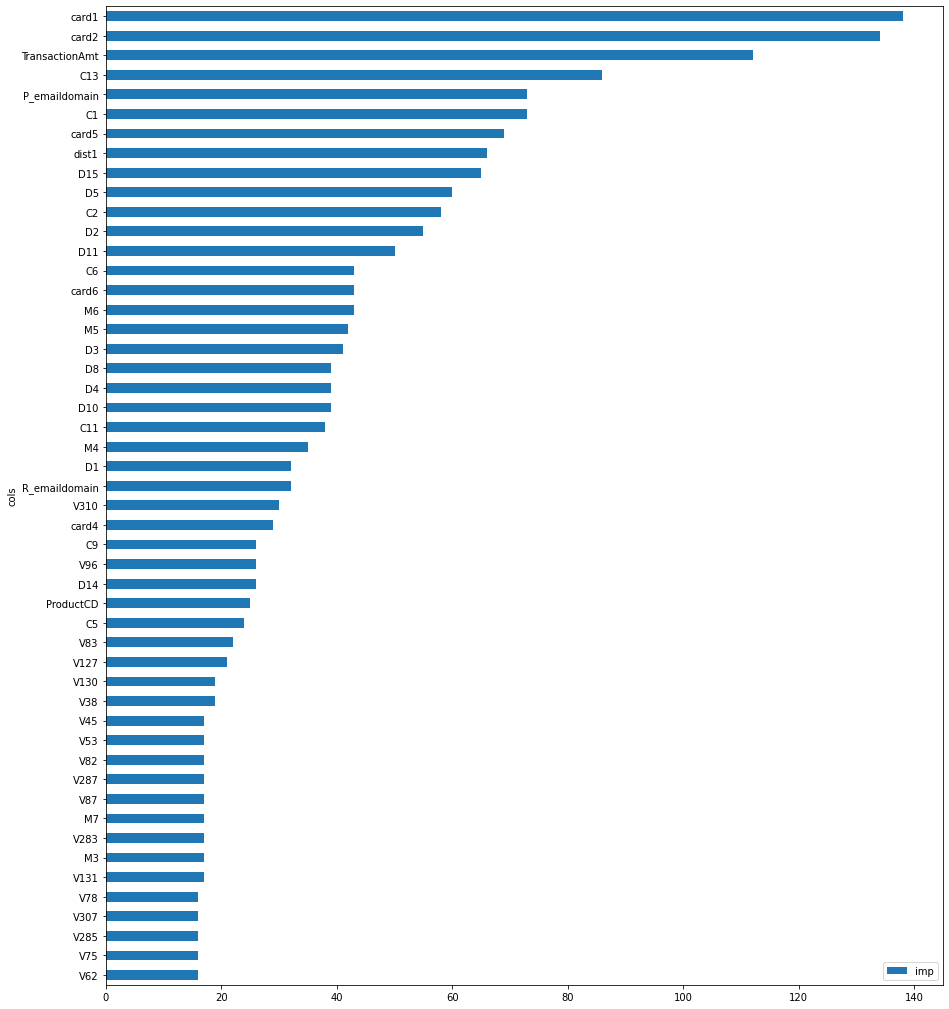

In [45]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf_LGBM.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

Using  GridSearchCv 


In [ ]:
param_grid = {
    'n_estimators': [500, 600],
    'colsample_bytree': [ 0.8, 1],
    'learning_rate': [0.1,0.2],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9, ],
    'min_child_samples': [10,20],
    'subsample_freq': [20,30]
    
    
}
clf_LGBM = lgbm.LGBMClassifier(objective='binary',is_unbalance= True)


grid_search_lgbm= GridSearchCV(estimator = clf_LGBM, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data 
grid_search_lgbm.fit(x_train, y_train)
grid_search_lgbm.best_params_

best_grid_lgbm = grid_search_lgbm.best_estimator_


y_pred_train_grid_rf= grid_search_lgbm .predict(x_train)
y_pred_grid_valid_rf= grid_search_lgbm .predict(x_valid)
# Model Accuracy, how often is the classifier correct?

print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train_grid_rf)) 

print("Test Accuracy:",metrics.accuracy_score(y_valid, y_pred_valid_train_rf))  
print(classification_report(y_valid, y_pred_grid_valid_rf))

Fitting 3 folds for each of 10368 candidates, totalling 31104 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 57.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 105.2min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 159.6min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 230.9min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 316.4min


 1.  DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields ProductCD, card4, card6, P_emaildomain, R_emaildomain, M1, M2, M3, M4, M5, M6, M7, M8, M9
2.  not able to define class_weight

In [46]:
param_grid1= {
    'n_estimators': [200, 500],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'learning_rate': [0.1,0.2],
    'max_depth': [15,20],
    'num_leaves': [50, 100, 150],
    'reg_alpha': [1.1, 1.2],
    'reg_lambda': [1.1, 1.2],
    'min_split_gain': [0.3, 0.4],
    'subsample': [ 0.8, 0.9 ],
    'min_child_samples': [10,20],
    'subsample_freq': [20,30]
  
    
}
clf_LGBM1 = lgbm.LGBMClassifier(objective='binary',is_unbalance= True)


grid_search_lgbm1= RandomizedSearchCV(estimator = clf_LGBM1,  param_distributions= param_grid1, n_iter = 10,
                          cv = 3, n_jobs = -1, verbose = 2, random_state=100 )


# Fit the grid search to the data 
grid_search_lgbm1.fit(x_train, y_train)
grid_search_lgbm1.best_params_

best_grid_lgbm1 = grid_search_lgbm1.best_estimator_


y_pred_train_grid_rf1= grid_search_lgbm1 .predict(x_train)
y_pred_grid_valid_rf1= grid_search_lgbm1 .predict(x_valid)
# Model Accuracy, how often is the classifier correct?

print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train_grid_rf1)) 

print("Valid Accuracy:",metrics.accuracy_score(y_valid, y_pred_grid_valid_rf1))  
print(classification_report(y_valid, y_pred_grid_valid_rf1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.5min finished


Train Accuracy: 0.99621875
Valid Accuracy: 0.9673032696730327
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9649
           1       0.54      0.50      0.52       352

    accuracy                           0.97     10001
   macro avg       0.76      0.74      0.75     10001
weighted avg       0.97      0.97      0.97     10001



In [47]:
best_grid_lgbm1

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=15, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.3, n_estimators=200, n_jobs=-1, num_leaves=150,
               objective='binary', random_state=None, reg_alpha=1.1,
               reg_lambda=1.2, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=20)

best of RandomSearchcv parameters

In [48]:
clf_LGBM2 = lgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=15, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.3, n_estimators=200, n_jobs=-1, num_leaves=150,
               objective='binary', random_state=None, reg_alpha=1.1,
               reg_lambda=1.2, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=20)

# Fit the grid search to the data 
clf_LGBM2.fit(x_train, y_train)

# best_grid_lgbm1 = grid_search_lgbm1.best_estimator_


y_pred_train_grid_rf2= clf_LGBM2 .predict(x_train)
y_pred_grid_valid_rf2= clf_LGBM2 .predict(x_valid)
# Model Accuracy, how often is the classifier correct?

print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train_grid_rf2)) 

print("Test Accuracy:",metrics.accuracy_score(y_valid, y_pred_grid_valid_rf2))  
print(classification_report(y_valid, y_pred_grid_valid_rf2))

Train Accuracy: 0.99621875
Test Accuracy: 0.9673032696730327
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9649
           1       0.54      0.50      0.52       352

    accuracy                           0.97     10001
   macro avg       0.76      0.74      0.75     10001
weighted avg       0.97      0.97      0.97     10001



In [49]:
litraincolOrg = x_train.columns
livalidcolOrg = x_valid.columns

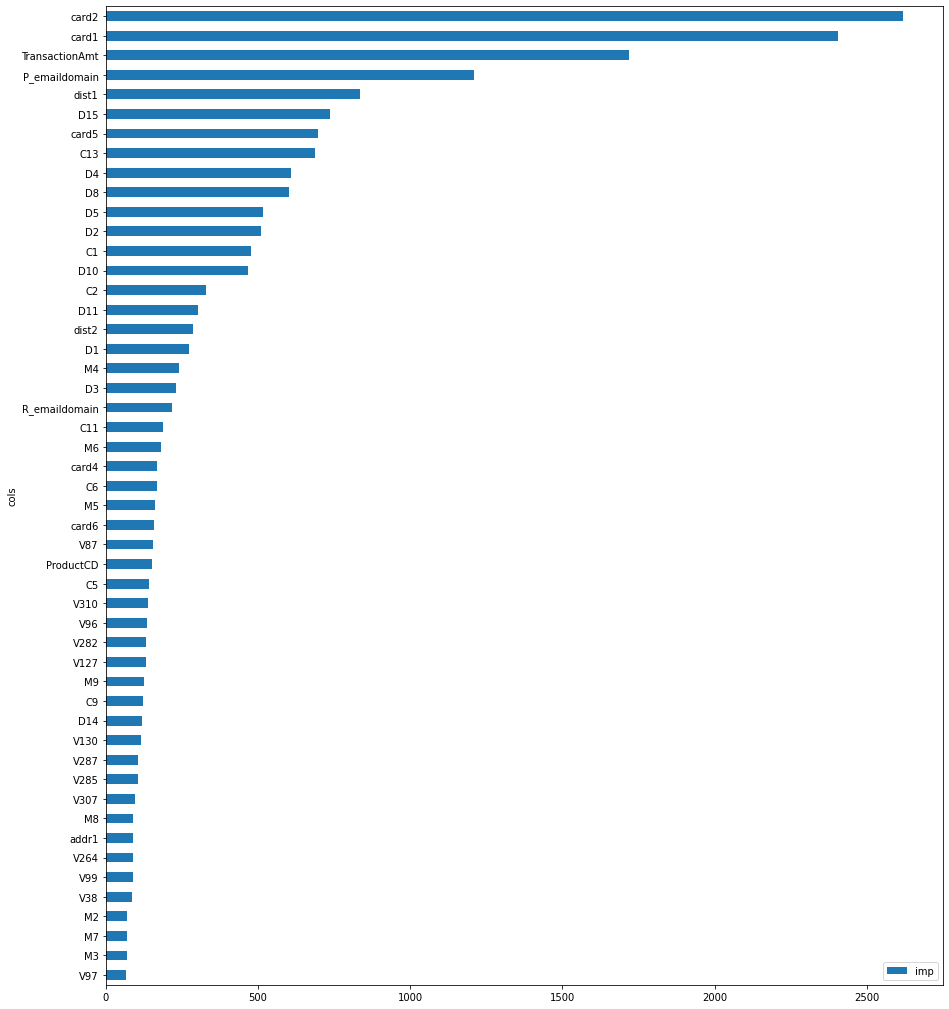

In [50]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf_LGBM2.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()